<a href="https://colab.research.google.com/github/SusimRoy/flight-price-prediction/blob/main/flight_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [111]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import neighbors
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import joblib
import pickle
from torch import nn
import keras
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten,Conv2D, Dropout,MaxPooling1D,BatchNormalization
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xg
from sklearn.utils import shuffle
from sklearn.svm import SVR
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
from sklearn import linear_model
from torchsummary import summary
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from torch.autograd import Variable
import warnings
from sklearn import linear_model
from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [112]:
path = '/content/drive/MyDrive/PRML_Bonus/Dataset.xlsx'

In [113]:
data = pd.read_excel(path)
data

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


##Preprocessing

In [114]:
data.Date_of_Journey = data.Date_of_Journey.str.split('/')

In [115]:
#Making 3 new columns
data['Date'] = data.Date_of_Journey.str[0]
data['Month'] = data.Date_of_Journey.str[1]
data['Year'] = data.Date_of_Journey.str[2]

In [116]:
data.Route = data.Route.str.split('→')

In [117]:
#Making 4 new columns as per the cities
data['City1'] = data.Route.str[0]
data['City2'] = data.Route.str[1]
data['City3'] = data.Route.str[2]
data['City4'] = data.Route.str[3]

In [118]:
#Making 2 new columns as per the departure time
data.Dep_Time = data.Dep_Time.str.split(':')
data['Dep_Hour'] = data.Dep_Time.str[0]
data['Dep_Minute'] = data.Dep_Time.str[1]

In [119]:
#Making 3 new columns as per the arrival date
data.Arrival_Time = data.Arrival_Time.str.split(' ')
data['Arrival_date'] = data.Arrival_Time.str[1]
data['Time_of_Arrival'] = data.Arrival_Time.str[0]
data['Time_of_Arrival'] = data.Time_of_Arrival.str.split(':')

In [120]:
data['Arrival_Time_Hour'] = data.Time_of_Arrival.str[0]
data['Arrival_Time_Minute'] = data.Time_of_Arrival.str[1]

In [121]:
#Making 2 new columns as per the Duration
data.Duration = data.Duration.str.split(' ')
data['Travel_Hours'] = data.Duration.str[0]
data['Travel_Hours'] = data['Travel_Hours'].str.split('h')
data['Travel_Hours'] = data['Travel_Hours'].str[0]
data.Travel_Hours = data.Travel_Hours

In [122]:
data['Travel_mins'] = data.Duration.str[1]
data.Travel_mins = data.Travel_mins.str.split('m')
data.Travel_mins = data.Travel_mins.str[0]

In [123]:
data.Total_Stops.replace('non-stop','0',inplace=True)
data.Total_Stops = data.Total_Stops.str.split(' ')
data.Total_Stops = data.Total_Stops.str[0]

In [124]:
data.Additional_Info.replace('No Info', 'No info', inplace=True)

In [125]:
data.isnull().sum() # Checking for null values

Airline                   0
Date_of_Journey           0
Source                    0
Destination               0
Route                     1
Dep_Time                  0
Arrival_Time              0
Duration                  0
Total_Stops               1
Additional_Info           0
Price                     0
Date                      0
Month                     0
Year                      0
City1                     1
City2                     1
City3                  3492
City4                  9117
Dep_Hour                  0
Dep_Minute                0
Arrival_date           6348
Time_of_Arrival           0
Arrival_Time_Hour         0
Arrival_Time_Minute       0
Travel_Hours              0
Travel_mins            1032
dtype: int64

In [126]:
data['City3'].fillna('None',inplace = True)
data['Arrival_date'].fillna(data['Date'],inplace = True)
data['Travel_mins'].fillna(0,inplace=True)

In [127]:
data = data.drop(columns=['City4','Date_of_Journey','Route','Time_of_Arrival','Duration','Arrival_Time','Dep_Time'],axis=1) #Dropping columns with many nul values

In [128]:
data.iloc[9039,3] = 0
data.iloc[9039,9] = 'DEL'
data.iloc[9039,10] = 'COK'
data.iloc[9039,11] = None

In [129]:
#Converting the data into integer values
data.Total_Stops = data.Total_Stops.astype('int64')
data.Date = data.Date.astype('int64')
data.Month = data.Month.astype('int64')
data.Year = data.Year.astype('int64')
data.Dep_Hour = data.Dep_Hour.astype('int64')
data.Dep_Minute = data.Dep_Minute.astype('int64')
data.Arrival_date = data.Arrival_date.astype('int64')
data.Arrival_Time_Hour = data.Arrival_Time_Hour.astype('int64')
data.Arrival_Time_Minute = data.Arrival_Time_Minute.astype('int64')
data.Travel_mins = data.Travel_mins.astype('int64')

In [130]:
data.drop(index = 6474, inplace = True, axis = 0)

#### Visualizing data

In [131]:
num = ['Total_Stops','Date','Month','Year','Dep_Hour','Dep_Minute','Arrival_date','Arrival_Time_Hour','Arrival_Time_Minute','Travel_Hours','Travel_mins']

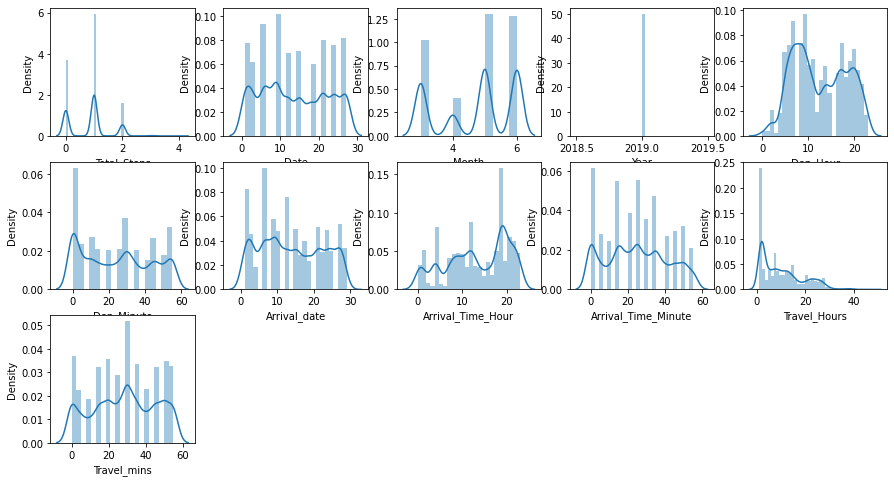

In [132]:
#Visualising the distribution of the feature columns
warnings.filterwarnings("ignore")
plt.figure(figsize=(15,8))
r = 1
for i in range(len(num)):
  plt.subplot(3,5,r)
  sns.distplot(data[num[i]])
  r+=1

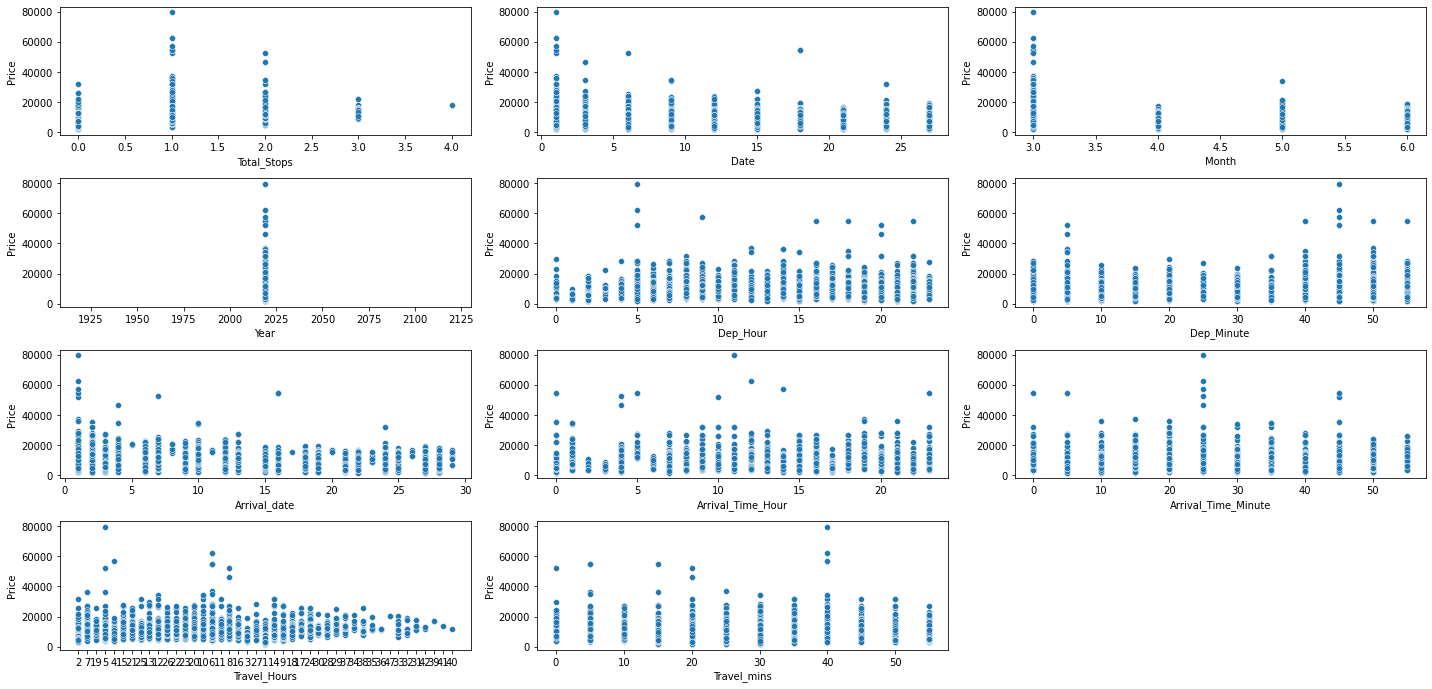

In [133]:
#Viewing the relationship between feature columns and price column
r = 1
plt.figure(figsize = (20,14))
for i in num:
  plt.subplot(6,3,r)
  sns.scatterplot(x = data[i],y=data.Price)
  plt.tight_layout()
  r+=1

#### Final dataset

In [134]:
data.Travel_Hours = data.Travel_Hours.astype('int64')

In [135]:
data = data.drop(columns=['Dep_Minute','Arrival_Time_Minute','Travel_mins','Year', 'City1']) #Dropping Unnecessary columns

In [136]:
data.Travel_Hours = np.log(data.Travel_Hours)

In [137]:
le = LabelEncoder()
for i in data.columns:
  if data[i].dtypes == 'object':
    data[i] = le.fit_transform(data[i])

In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Airline            10682 non-null  int64  
 1   Source             10682 non-null  int64  
 2   Destination        10682 non-null  int64  
 3   Total_Stops        10682 non-null  int64  
 4   Additional_Info    10682 non-null  int64  
 5   Price              10682 non-null  int64  
 6   Date               10682 non-null  int64  
 7   Month              10682 non-null  int64  
 8   City2              10682 non-null  int64  
 9   City3              10682 non-null  int64  
 10  Dep_Hour           10682 non-null  int64  
 11  Arrival_date       10682 non-null  int64  
 12  Arrival_Time_Hour  10682 non-null  int64  
 13  Travel_Hours       10682 non-null  float64
dtypes: float64(1), int64(13)
memory usage: 1.2 MB


In [139]:
#Creating dataset
X = data.drop('Price', axis = 1)
y = data['Price']

In [140]:
X

,Airline,Source,Destination,Total_Stops,Additional_Info,Date,Month,City2,City3,Dep_Hour,Arrival_date,Arrival_Time_Hour,Travel_Hours
0,3,0,5,0,7,24,3,13,29,22,22,1,0.693147
1,1,3,0,2,7,1,5,25,1,5,1,13,1.945910
2,4,2,1,2,7,9,6,32,4,9,10,4,2.944439
3,3,3,0,1,7,12,5,34,3,18,12,23,1.609438
4,3,0,5,1,7,1,3,34,8,16,1,21,1.386294
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0,3,0,0,7,9,4,5,29,19,9,22,0.693147
10679,1,3,0,0,7,27,4,5,29,20,27,23,0.693147
10680,4,0,2,0,7,27,4,13,29,8,27,11,1.098612
10681,10,0,5,0,7,1,3,13,29,11,1,14,0.693147


In [141]:
y

0         3897
1         7662
2        13882
3         6218
4        13302
         ...  
10678     4107
10679     4145
10680     7229
10681    12648
10682    11753
Name: Price, Length: 10682, dtype: int64

In [142]:
from sklearn.model_selection import train_test_split
x_train , x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

##Implementing different models

####Initialization

In [143]:
models = []
preds = []

###K-NN

In [144]:
rmse_val1 = [] 
for K in range(20): # Finding the best value of K
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)  
    pred=model.predict(x_test) 
    error = sqrt(mean_squared_error(y_test,pred))
    rmse_val1.append(error) 
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 2938.4975261838244
RMSE value for k=  2 is: 2710.360842199761
RMSE value for k=  3 is: 2693.321266474619
RMSE value for k=  4 is: 2696.2590300882243
RMSE value for k=  5 is: 2726.8441738377965
RMSE value for k=  6 is: 2756.2089618504956
RMSE value for k=  7 is: 2795.139709401209
RMSE value for k=  8 is: 2832.6766676711695
RMSE value for k=  9 is: 2866.518748597426
RMSE value for k=  10 is: 2888.410015463895
RMSE value for k=  11 is: 2897.3527532595726
RMSE value for k=  12 is: 2915.8976957390637
RMSE value for k=  13 is: 2937.667168534249
RMSE value for k=  14 is: 2957.225116147236
RMSE value for k=  15 is: 2980.713774878492
RMSE value for k=  16 is: 3003.2215260671974
RMSE value for k=  17 is: 3012.361590200584
RMSE value for k=  18 is: 3023.35850439235
RMSE value for k=  19 is: 3033.50021965722
RMSE value for k=  20 is: 3043.4050100736927


R2-score is:  0.6655369962190905
Max_depth =  3 gives the lowest rmse which is:  2693.321266474619
MAE is:  1603.7421736869474


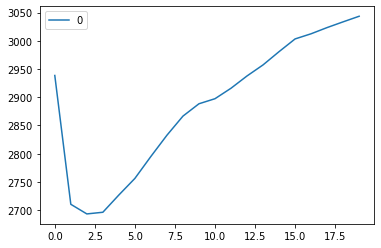

In [145]:
curve = pd.DataFrame(rmse_val1)
curve.plot()
#Training on best model
model = neighbors.KNeighborsRegressor(n_neighbors = np.argmin(rmse_val1)+1)
model.fit(x_train, y_train)  
models.append(model)
pred=model.predict(x_test) 
preds.append(pred)
#Training on best model
r2_knn = r2_score(y_true=y_test, y_pred=pred)
print("R2-score is: ", r2_knn)
print("Max_depth = ", np.argmin(rmse_val1)+1,"gives the lowest rmse which is: " , rmse_val1[np.argmin(rmse_val1)])
rmse_knn = rmse_val1[np.argmin(rmse_val1)]
mae_knn = mean_absolute_error(y_test, pred)
print("MAE is: ",mae_knn)

###Tree Regressors

In [146]:
rmse_val2 = [] 
for K in range(20): # Finding the best value of max depth
    K = K+1
    model = DecisionTreeRegressor(max_depth = K)

    model.fit(x_train, y_train)  
    pred=model.predict(x_test) 
    error = sqrt(mean_squared_error(y_test,pred))
    rmse_val2.append(error) 
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 3616.305754460437
RMSE value for k=  2 is: 3428.695578761221
RMSE value for k=  3 is: 3297.318158705144
RMSE value for k=  4 is: 3249.4317493724
RMSE value for k=  5 is: 2924.0446580365924
RMSE value for k=  6 is: 2757.52908657588
RMSE value for k=  7 is: 2491.029980476921
RMSE value for k=  8 is: 2392.9534384173467
RMSE value for k=  9 is: 2317.2912464309643
RMSE value for k=  10 is: 2238.3474467884
RMSE value for k=  11 is: 2227.9558240220053
RMSE value for k=  12 is: 2133.072933950404
RMSE value for k=  13 is: 2146.7479122103523
RMSE value for k=  14 is: 2146.7687024656066
RMSE value for k=  15 is: 2148.1198748107254
RMSE value for k=  16 is: 2149.551769365571
RMSE value for k=  17 is: 2162.1834631373076
RMSE value for k=  18 is: 2159.612259234162
RMSE value for k=  19 is: 2160.5463210977277
RMSE value for k=  20 is: 2187.5386612972957


R2-score is:  0.7883323660190424
Max_depth =  12 gives the lowest rmse which is:  2133.072933950404
MAE is:  887.6127656309837


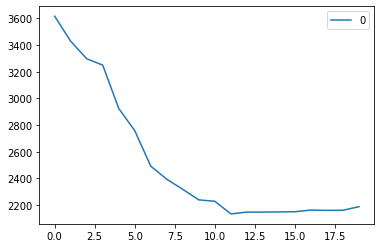

In [147]:
curve = pd.DataFrame(rmse_val2)
curve.plot()
#Training on best model
model = DecisionTreeRegressor(max_depth = np.argmin(rmse_val2)+1)
model.fit(x_train, y_train)  
models.append(model)
joblib.dump(model, "Price_dtr.pkl")
pred=model.predict(x_test) 
preds.append(pred)
#Training on best model
r2_dtr = r2_score(y_true=y_test, y_pred=pred)
print("R2-score is: ", r2_dtr)
print("Max_depth = ", np.argmin(rmse_val2)+1,"gives the lowest rmse which is: " , rmse_val2[np.argmin(rmse_val2)])
rmse_dtr = rmse_val2[np.argmin(rmse_val2)]
mae_dtr = mean_absolute_error(y_test, pred)
print("MAE is: ",mae_dtr)

In [148]:
rmse_val2 = [] 
for K in range(20): # Finding the best value of max depth
    K = K+1
    model = RandomForestRegressor(max_depth = K,n_estimators = 35)

    model.fit(x_train, y_train)  
    pred=model.predict(x_test) 
    error = sqrt(mean_squared_error(y_test,pred))
    rmse_val2.append(error) 
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 3616.6502393986643
RMSE value for k=  2 is: 3408.140129225616
RMSE value for k=  3 is: 3198.9356130858355
RMSE value for k=  4 is: 2954.529511921262
RMSE value for k=  5 is: 2656.4073214540444
RMSE value for k=  6 is: 2447.9721293483303
RMSE value for k=  7 is: 2217.716251748813
RMSE value for k=  8 is: 2090.830697236339
RMSE value for k=  9 is: 1994.593067916546
RMSE value for k=  10 is: 2011.087126596637
RMSE value for k=  11 is: 1963.074513712495
RMSE value for k=  12 is: 1879.3781298667539
RMSE value for k=  13 is: 1844.4963528366616
RMSE value for k=  14 is: 1892.1690740244637
RMSE value for k=  15 is: 1872.4607210062145
RMSE value for k=  16 is: 1898.9346767316977
RMSE value for k=  17 is: 1914.4485033228414
RMSE value for k=  18 is: 1853.5294230359875
RMSE value for k=  19 is: 1886.8709959718587
RMSE value for k=  20 is: 1913.8003882449982


R2-score is:  0.8284381880438823
Max_depth =  13 gives the lowest rmse which is:  1844.4963528366616
MAE is:  764.2266068410913


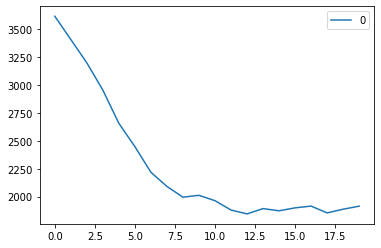

In [149]:
curve = pd.DataFrame(rmse_val2) #elbow curve 
curve.plot()
#Training on best model
model = RandomForestRegressor(max_depth = np.argmin(rmse_val2)+1)
model.fit(x_train, y_train)  
models.append(model)
joblib.dump(model, "Price_rfc.pkl")
pred=model.predict(x_test) 
preds.append(pred)
#Training on best model
r2_rfc = r2_score(y_true=y_test, y_pred=pred)
print("R2-score is: ", r2_rfc)
print("Max_depth = ", np.argmin(rmse_val2)+1,"gives the lowest rmse which is: " , rmse_val2[np.argmin(rmse_val2)])
rmse_rfc = rmse_val2[np.argmin(rmse_val2)]
mae_rfc = mean_absolute_error(y_test, pred)
print("MAE is: ",mae_rfc)

###CNN

In [150]:
#Training a neural network
model = Sequential()
model.add(Conv1D(256, 3, padding='same', activation="relu", input_shape=(x_train.shape[1],1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(128, 3,padding='same', activation="relu"))
#model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(128, 3,padding='same',activation="relu"))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2)) 
model.add(Dense(1))
model.compile(loss ='mean_squared_error', optimizer = "RMSProp")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 13, 256)           1024      
                                                                 
 batch_normalization_1 (Batc  (None, 13, 256)          1024      
 hNormalization)                                                 
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 4, 256)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 4, 128)            98432     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                      

In [151]:
model.fit(x_train, y_train, batch_size=32,epochs=100, verbose=1)
model.save('Price.h5')

Epoch 1/100
234/234 [==============================] - 5s 10ms/step - loss: 27958496.0000
Epoch 2/100
234/234 [==============================] - 3s 12ms/step - loss: 12618828.0000
Epoch 3/100
234/234 [==============================] - 3s 11ms/step - loss: 11330774.0000
Epoch 4/100
234/234 [==============================] - 3s 12ms/step - loss: 10181026.0000
Epoch 5/100
234/234 [==============================] - 3s 12ms/step - loss: 9885547.0000
Epoch 6/100
234/234 [==============================] - 3s 11ms/step - loss: 9500353.0000
Epoch 7/100
234/234 [==============================] - 3s 12ms/step - loss: 8976120.0000
Epoch 8/100
234/234 [==============================] - 3s 12ms/step - loss: 8583996.0000
Epoch 9/100
234/234 [==============================] - 3s 12ms/step - loss: 8285460.0000
Epoch 10/100
234/234 [==============================] - 3s 11ms/step - loss: 7926396.5000
Epoch 11/100
234/234 [==============================] - 3s 12ms/step - loss: 7801396.5000
Epoch 12/100
23

234/234 [==============================] - 1s 3ms/step - loss: 3350804.2500
3350804.25
R2-score on test set is:  0.7631618671348337
RMSE on test set is: 2266.4176
MAE on test set is:  1508.8915584094068


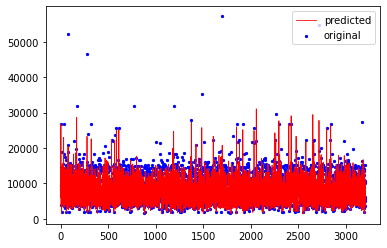

In [152]:
models.append(model)
ypred = model.predict(x_test)
preds.append(ypred)
print(model.evaluate(x_train, y_train))
r2_cnn = r2_score(y_true=y_test, y_pred=ypred)
print("R2-score on test set is: ", r2_cnn)
rmse_cnn = sqrt(mean_squared_error(y_test, ypred))
print("RMSE on test set is: %.4f" % sqrt(mean_squared_error(y_test, ypred)))
mae_cnn = mean_absolute_error(y_test, ypred)
print("MAE on test set is: ",mae_cnn)

x_ax = range(len(ypred))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

###MLP

In [153]:
X_train = np.array(x_train).astype(np.float32)
X_test = np.array(x_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

In [154]:
batch_size = 32 
num_epochs = 400 
learning_rate = 0.01
batch_no = len(X_train) // batch_size 
cols = X_train.shape[1]

In [155]:
class MLP(nn.Module): # Defining the class for a multi-layer perceptron with 2 hidden layers
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(13, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 1)
    )
  def forward(self, x):
    return self.layers(x)

net = MLP()
summary(net,(1,13))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]             896
              ReLU-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 32]           2,080
              ReLU-4                [-1, 1, 32]               0
            Linear-5                 [-1, 1, 1]              33
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [156]:
optimizer = torch.optim.Adam(net.parameters(), weight_decay=0.0001)
loss_func = torch.nn.MSELoss() 

for epoch in range(num_epochs):

    X_train, y_train = shuffle(X_train, y_train)
    current_loss = 0.0
    for i in range(batch_no):

        start = i * batch_size
        end = start + batch_size
        inputs = Variable(torch.FloatTensor(X_train[start:end]))
        labels = Variable(torch.FloatTensor(y_train[start:end]))

        outputs = net(inputs)
        c = outputs.flatten()

        loss = loss_func(c, labels)


        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        current_loss += loss.item()

        if i % 10 == 0:

          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

Streaming output truncated to the last 5000 lines.
Loss after mini-batch   161: 130212.837
Loss after mini-batch   171: 135328.006
Loss after mini-batch   181: 147786.269
Loss after mini-batch   191: 141869.986
Loss after mini-batch   201: 256113.726
Loss after mini-batch   211: 161167.674
Loss after mini-batch   221: 346413.394
Loss after mini-batch   231: 114080.287
Loss after mini-batch     1: 10319.450
Loss after mini-batch    11: 140005.963
Loss after mini-batch    21: 107676.355
Loss after mini-batch    31: 139770.388
Loss after mini-batch    41: 196112.166
Loss after mini-batch    51: 138359.095
Loss after mini-batch    61: 157978.683
Loss after mini-batch    71: 121209.966
Loss after mini-batch    81: 130230.099
Loss after mini-batch    91: 115572.705
Loss after mini-batch   101: 203081.472
Loss after mini-batch   111: 138614.293
Loss after mini-batch   121: 376436.258
Loss after mini-batch   131: 145054.057
Loss after mini-batch   141: 347398.118
Loss after mini-batch   151: 1

In [157]:
inputs2 = Variable(torch.FloatTensor(X_test))
labels2 = Variable(torch.FloatTensor(y_test))
models.append(net)
outputs = net(inputs2).detach().numpy()
preds.append(outputs)
r2_mlp = r2_score(y_true=labels2, y_pred=outputs)
print("R2-score is: ", r2_mlp)
error = sqrt(mean_squared_error(labels2,outputs))
rmse_mlp = error
print("RMSE LOSS: ",error)
mae_mlp = mean_absolute_error(labels2, outputs)
print("MAE is: ",mae_mlp)

R2-score is:  0.7241580065681681
RMSE LOSS:  2445.931519891757
MAE is:  1623.5632


###XGBoost

In [158]:
xgb_r = xg.XGBRegressor(objective ='reg:squarederror',n_estimators = 60,max_depth = 4) # Defining the best object after manual hyperparameter tuning
xgb_r.fit(x_train,y_train)
models.append(xgb_r)
pred = xgb_r.predict(x_test)
preds.append(pred)
rmse_xgb = sqrt(mean_squared_error(pred,y_test))
r2_xgb = r2_score(y_true=y_test, y_pred=pred)
mae_xgb = mean_absolute_error(y_test, pred)
print("R2-score is: ", r2_xgb)
print("RMSE for xgboost: ",rmse_xgb)
print("MAE is: ",mae_xgb)

R2-score is:  0.006978056837199653
RMSE for xgboost:  4640.807257363745
MAE is:  3647.2861


###SVM

In [159]:
regr = make_pipeline(StandardScaler(), SVR(C=20.0, epsilon=0.2,kernel='linear')) # Defining the best object after manual hyperparameter tuning
xgb_r.fit(x_train,y_train)
regr.fit(x_train, y_train)
models.append(regr)
pred = regr.predict(x_test)
preds.append(pred)
r2_svm = r2_score(y_true=y_test, y_pred=pred)
rmse_svm = sqrt(mean_squared_error(pred,y_test))
mae_svm = mean_absolute_error(y_test, pred)
print("R2-score is: ", r2_svm)
print("RMSE for svm: ",rmse_svm)
print("MAE is: ",mae_svm)

R2-score is:  -0.050939250170359385
RMSE for svm:  4774.225420885815
MAE is:  3662.324532877255


###Lasso

In [160]:
clf = linear_model.Lasso(alpha=0.1,max_iter = 5000) # Defining the best object after manual hyperparameter tuning
xgb_r.fit(x_train,y_train)
clf.fit(x_train,y_train)
models.append(clf)
pred = clf.predict(x_test)
preds.append(pred)
r2_lasso = r2_score(y_true=y_test, y_pred=pred)
rmse_lasso = sqrt(mean_squared_error(pred,y_test))
mae_lasso = mean_absolute_error(y_test, pred)
print("R2-score for svm is: ", r2_lasso)
print("RMSE for svm is: ",rmse_lasso)
print("MAE is: ",mae_lasso)

R2-score for svm is:  0.0019843238923050732
RMSE for svm is:  4652.461588823541
MAE is:  3665.589623291491


###AdaBoost

In [161]:
rfc = RandomForestRegressor()
clf = AdaBoostRegressor(base_estimator = rfc,n_estimators=35,learning_rate = 0.01) # Defining the best object after manual hyperparameter tuning
xgb_r.fit(x_train,y_train)
clf.fit(x_train,y_train)
models.append(clf)
pred = clf.predict(x_test)
preds.append(pred)
r2_ada = r2_score(y_true=y_test, y_pred=pred)
rmse_ada = sqrt(mean_squared_error(pred,y_test))
mae_ada = mean_absolute_error(y_test, pred)
print("R2-score for svm is: ", r2_ada)
print("RMSE for svm is: ",rmse_ada)
print("MAE is: ",mae_ada)

R2-score for svm is:  -0.13121992376644132
RMSE for svm is:  4953.220225066814
MAE is:  3869.1743497784314


##Performance Visualization

###Metrics

In [162]:
r2_scores = [r2_knn,r2_dtr,r2_rfc,r2_cnn,r2_mlp,r2_svm,r2_xgb,r2_lasso,r2_ada]
rmse_scores = [rmse_knn,rmse_dtr,rmse_rfc,rmse_cnn,rmse_mlp,rmse_svm,rmse_xgb,rmse_lasso,rmse_ada]
mae_scores = [mae_knn,mae_dtr,mae_rfc,mae_cnn,mae_mlp,mae_svm,mae_xgb,mae_lasso,mae_ada]
data = pd.DataFrame()
data['Models'] = ['KNN','Decision-Tree','Random-Forest','CNN','MLP','SVM','XGBoost','Lasso','AdaBoost']
data['RMSE'] = rmse_scores
data['R2-Score'] = r2_scores
data['MAE'] = mae_scores
data

,Models,RMSE,R2-Score,MAE
0,KNN,2693.321266,0.665537,1603.742174
1,Decision-Tree,2133.072934,0.788332,887.612766
2,Random-Forest,1844.496353,0.828438,764.226607
3,CNN,2266.417588,0.763162,1508.891558
4,MLP,2445.931520,0.724158,1623.563232
5,SVM,4774.225421,-0.050939,3662.324533
6,XGBoost,4640.807257,0.006978,3647.286133
7,Lasso,4652.461589,0.001984,3665.589623
8,AdaBoost,4953.220225,-0.131220,3869.174350


###Visualization

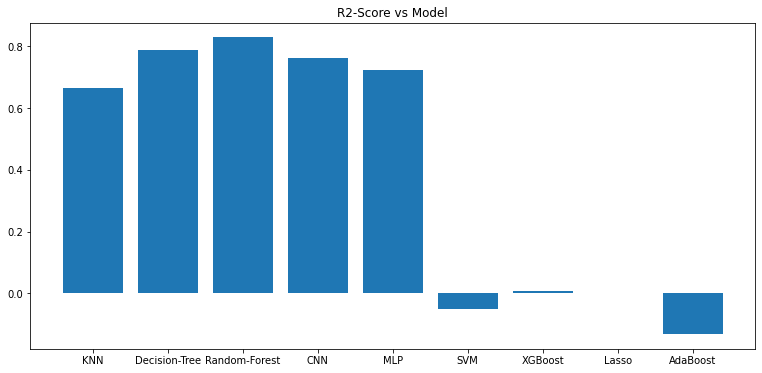

In [163]:
#Visualizing R2-Score vs Model
plt.figure(figsize=(13,6))
plt.bar(data['Models'],r2_scores)
plt.title('R2-Score vs Model')
plt.show()

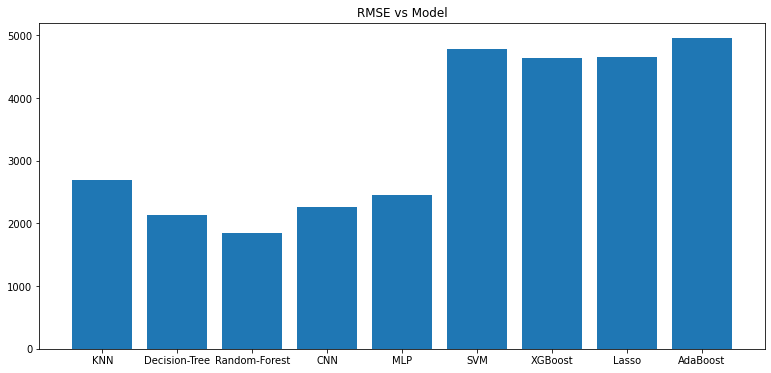

In [164]:
#Visualizing RMSE vs Model
plt.figure(figsize=(13,6))
plt.bar(data['Models'],rmse_scores)
plt.title('RMSE vs Model')
plt.show()

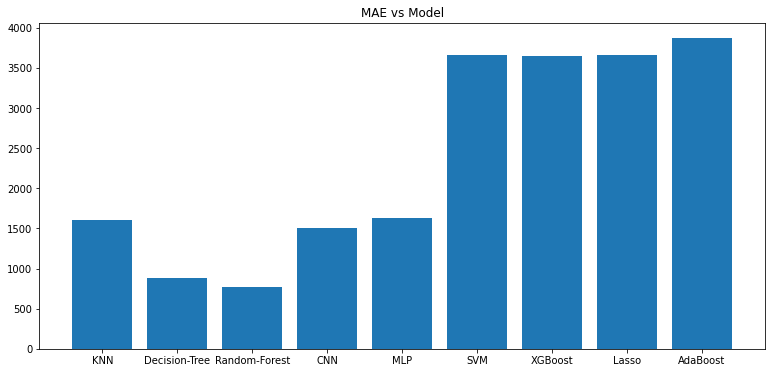

In [165]:
#Visualizing MAE vs Model
plt.figure(figsize=(13,6))
plt.bar(data['Models'],mae_scores)
plt.title('MAE vs Model')
plt.show()

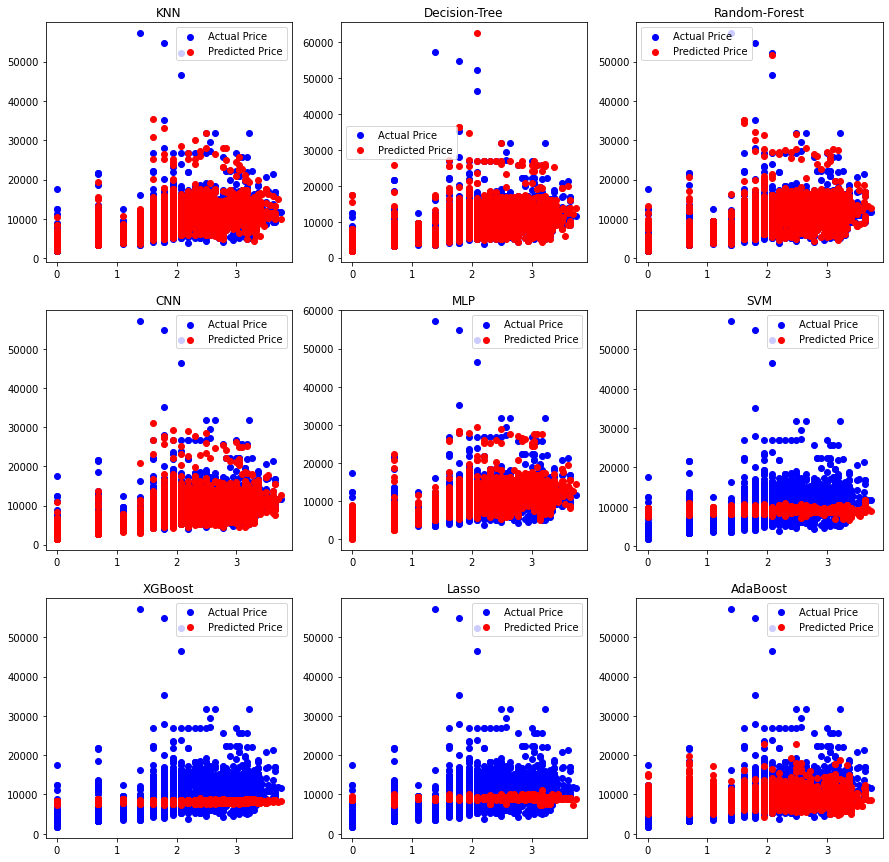

In [166]:
#Visualizing actual vs predicted data for each model
plt.figure(figsize=(15,15))
r = range(1,10)
for i,pred in enumerate(preds):
  plt.subplot(3,3,r[i])
  plt.scatter(x_test.iloc[:,-1],y_test,color='b',label='Actual Price')
  plt.scatter(x_test.iloc[:,-1],pred,color='r',label='Predicted Price')
  plt.title(data['Models'][i])
  plt.legend()

##Pipeline

In [170]:
class PipeLine():

  def __init__(self,dataset,model="RFC"):
    self.X = dataset.drop('Price',axis=1)
    self.y = dataset['Price']
  
  def load_file(self,filename):
    infile = open(filename,'rb')
    model = pickle.load(infile)
    infile.close()
    return model

  def use_model(self,model):

    if model == "RFC":
      self.rfc = self.load_file('Price_rfc.pkl')
      self.pred = self.rfc.predict(self.X)
    if model == "CNN":
      cnn = keras.models.load_model('Price.h5')
      self.pred = cnn.predict(self.X)
    if model == "DTR":
      self.dtr = self.load_file('Price_dtr.pkl')
      self.pred = self.dtr.predict(self.X)
    else:
      return

  def get_metrics(self,model):

    if model == "RFC":
      print("The R2-Score using ",model," is: ",r2_score(y_true=y, y_pred=self.pred))
      print("The MSE using ",model," is: ",sqrt(mean_squared_error(y, self.pred)))
    if model == "CNN":
      print("The R2-Score using ",model," is: ",r2_score(y_true=y, y_pred=self.pred))
      print("The MSE using ",model," is: ",sqrt(mean_squared_error(y, self.pred)))
    if model == "DTR":
      print("The R2-Score using ",model," is: ",r2_score(y_true=y, y_pred=self.pred))
      print("The MSE using ",model," is: ",sqrt(mean_squared_error(y, self.pred)))
  
  def runPipeline(self,model):
    print("model is running")
    self.use_model(model)
    print("getting metrics")
    self.get_metrics()

In [ ]:
pipe = PipeLine(data) # Here "data" is the user-inputted data
pipe.runPipeLine(model) # Here model is the user-inputted model